https://github.com/AnilOsmanTur/Classifying-The-ID-Visibility/blob/master/notebooks/4.%20Training%20splits%20and%20Training%20data.ipynb

In [1]:
!pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch: started
  Running setup.py install for pytorch: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\SHAIKH SOHEL\AppData\Local\Temp\pip-install-14l37iwu\pytorch_6d04c5a930b84ec4bbfdd5ed3d9c8b8b\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  error: subprocess-exited-with-error
  
  Running setup.py install for pytorch did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\SHAIKH SOHEL\Ap

In [2]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

Model Selection

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms


C:\Users\SHAIKH SOHEL\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (2.0.3)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


Deep feature extractor

In [4]:
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
print(mobilenet_feature[0][0])
print(mobilenet_feature[0][0].weight.shape)
# this is what we have pretrained and loaded

C:\Users\SHAIKH SOHEL\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SHAIKH SOHEL\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\SHAIKH SOHEL/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([32, 3, 3, 3])


In [5]:
one_Channel = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
print(one_Channel.weight.shape)
# but this is what we need to make the model functional for single-channel input


torch.Size([32, 1, 3, 3])


In [21]:
# so this will give us what we need
one_kernel = mobilenet_feature[0][0].weight[:,1]
one_kernel = torch.unsqueeze(one_kernel, dim=1).data
print(one_kernel.shape)
# now we can change the layer and save the weights
one_Channel.weight.data = one_kernel
mobilenet_feature[0][0] = one_Channel
torch.save(mobilenet_feature.state_dict(),r"C:\Users\SHAIKH SOHEL\Downloads\images-20221209T180836Z-001\modified_mobilenet_v2_features_state_dict.pth")


torch.Size([32, 1, 3, 3])


In [8]:
# let's test, does it load properly and give us the modified model
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
mobilenet_feature[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
mobilenet_feature.load_state_dict(torch.load(r"C:\Users\SHAIKH SOHEL\Downloads\images-20221209T180836Z-001\modified_mobilenet_v2_features_state_dict.pth"))

<All keys matched successfully>

In [9]:
# Dataset class to make loading easy and compatible with pytorch
class CardImageDataset():
    def __init__(self, root_dir=r"C:\Users\SHAIKH SOHEL\Downloads\images-20221209T180836Z-001", header_file='gicsd_labels.csv', image_dir='images'):
        '''
        root_dir: location of the dataset dir
        header_file: location of the dataset header in the dataset directory
        image_dir: location of the images
        '''
        header_path = os.path.join(root_dir,header_file)
        self.data_header = pd.read_csv(header_path, sep=', ', engine='python')
        self.image_dir = os.path.join(root_dir,image_dir)
        
        self.header_info, self.image_files, self.classes = self.header_info_extractor()
        self.length = len(self.image_files)
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        gray_image = self.load_image(self.image_files[idx])
        label = torch.LongTensor([self.header_info[idx,-1]])
        return {'image': gray_image, 'label': label}
        
    def load_image(self, image_file):
        '''
        image_file: file name of the image in dataset
        return: blue channel of the loaded image
        '''
        file_path = os.path.join(self.image_dir, image_file)
        frame = cv2.imread(file_path)[:,:,0].astype(np.float32)
        frame = torch.from_numpy(frame)
        frame /= 255
        frame = torch.unsqueeze(frame, dim=0)
        frame = transforms.functional.normalize(frame,
                                        mean=[0.406],
                                        std=[0.225])
        return frame
    
    def header_info_extractor(self):
        image_files = list(self.data_header['IMAGE_FILENAME'].values)
        labels = self.data_header['LABEL'].values.astype(str)
        label_set = sorted(list(set(labels)))

        new_data_block = []
        for row in zip(image_files, labels):
            file_name = row[0].split('_')
            new_data_block.append(file_name[1:-1] + [row[1]])    
        new_data_block = np.array(new_data_block)

        # chaning labels to numbers can help data processing
        for i, x in enumerate(label_set):
            new_data_block[new_data_block[:,-1] == x,-1] = i
        new_data_block = new_data_block.astype(np.int)
        return new_data_block, image_files, label_set

torch.Size([1, 192, 192])


C:\Users\SHAIKH SOHEL\AppData\Local\Temp\ipykernel_21616\2234616875.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_data_block = new_data_block.astype(np.int)


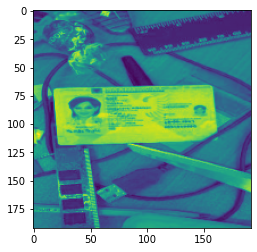

In [10]:
dataset = CardImageDataset(root_dir=r"C:\Users\SHAIKH SOHEL\Downloads\images-20221209T180836Z-001", header_file='gicsd_labels.csv', image_dir='images')

test_image = dataset[0]['image']
print(test_image.shape)
plt.imshow(test_image[0])

In [11]:
# try the forward pass of our feature model
test_image = torch.unsqueeze(test_image, dim=0)
with torch.no_grad():
    features = mobilenet_feature(test_image)
print(features.shape)

torch.Size([1, 1280, 6, 6])


Creating the classification model

In [14]:
from collections import OrderedDict

class CardModel(nn.Module):
    def __init__(self):
        super(CardModel, self).__init__()
        
        self.features = models.mobilenet_v2(pretrained=True).features
        self.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.features.load_state_dict(torch.load(r"C:\Users\SHAIKH SOHEL\Downloads\images-20221209T180836Z-001\modified_mobilenet_v2_features_state_dict.pth"))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('g_pool', nn.AdaptiveMaxPool2d(1)),
            ('flatten', nn.Flatten()),
            ('linear_1', nn.Linear(1280, 512)),
            ('act_1', nn.LeakyReLU()),
            
            ('linear_2', nn.Linear(512, 128)),
            ('act_2', nn.LeakyReLU()),
            
            ('linear_3', nn.Linear(128, 3)),
            ]))
        
        self.loss_1 = nn.CrossEntropyLoss()
    
    def forward(self, x):
        
        x = self.features(x)
        x = self.classifier(x)

        return x


In [15]:
cardNet = CardModel()
test_sample = dataset[0] 
test_image = test_sample['image']
label = test_sample['label']

test_image = torch.unsqueeze(test_image, dim=0)
print(label)
print(test_image.shape)
with torch.no_grad():
    out = cardNet(test_image)
    print('loss: ', cardNet.loss_1(out, label))
print(out.shape)
print(out)


tensor([0])
torch.Size([1, 1, 192, 192])
loss:  tensor(1.2244)
torch.Size([1, 3])
tensor([[-0.1538, -0.7136,  0.4511]])


In [16]:
test_image = dataset[0]['image']
test_image_1c = torch.unsqueeze(test_image, dim=0)
print(test_image_1c.shape)

test_image_3c = torch.cat([test_image,test_image,test_image],dim=0)
test_image_3c = torch.unsqueeze(test_image_3c, dim=0)
print(test_image_3c.shape)

torch.Size([1, 1, 192, 192])
torch.Size([1, 3, 192, 192])


In [17]:
mobilenet_feature = models.mobilenet_v2(pretrained=True).features
print(mobilenet_feature[0][0])

out_3c = mobilenet_feature[0][0](test_image_3c)
print(out_3c.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
torch.Size([1, 32, 96, 96])


In [18]:
one_Channel = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
one_kernel = mobilenet_feature[0][0].weight[:,2]
one_kernel = torch.unsqueeze(one_kernel, dim=1).data
one_Channel.weight.data = one_kernel

out_1c = one_Channel(test_image_1c)
print(out_1c.shape)

torch.Size([1, 32, 96, 96])


In [20]:
print('1 channel sum: {}\n3 channel sum: {}'.format(out_1c.sum(), out_3c.sum()))
print('1 channel avg: {}\n3 channel avg: {}'.format(out_1c.mean(), out_3c.mean()))
print('1 channel median: {}\n3 channel median: {}'.format(out_1c.median(), out_3c.median()))
print('1 channel std: {}\n3 channel std: {}'.format(out_1c.std(), out_3c.std()))
print('l1 loss: ', nn.functional.l1_loss(out_1c, out_3c))
print('mse loss: ', nn.functional.mse_loss(out_1c, out_3c))

1 channel sum: -1193.0859375
3 channel sum: -1045.2738037109375
1 channel avg: -0.004045566078275442
3 channel avg: -0.003544358303770423
1 channel median: 0.0002143416932085529
3 channel median: 0.0010061765788123012
1 channel std: 0.6812583208084106
3 channel std: 0.828816831111908
l1 loss:  tensor(0.5187, grad_fn=<MeanBackward0>)
mse loss:  tensor(0.7811, grad_fn=<MseLossBackward0>)
